In [4]:
import pandas as pd
import seaborn as snas
import matplotlib.pyplot as plt
import numpy as np
from ast import literal_eval # use literal eval instead of eval
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import jaccard_score
from scipy.sparse import csr_matrix

In [5]:
credits = pd.read_csv('../dataset/credits.csv')
keywords = pd.read_csv('../dataset/keywords.csv')
links = pd.read_csv('../dataset/links.csv')
md = pd.read_csv('../dataset/movies_metadata.csv')
ratings = pd.read_csv('../dataset/ratings.csv')

/var/folders/wy/xyqwny610cb9ft3dhglx4jyc0000gn/T/ipykernel_1985/2838257103.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  md = pd.read_csv('../dataset/movies_metadata.csv')


In [6]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

def embed_texts(sentences):
    embeddings = model.encode(sentences, normalize_embeddings=True)
    return embeddings

In [10]:
eval_columns = ['belongs_to_collection', 'production_companies', 'production_countries', 'spoken_languages', 'genres']

for eval_column in eval_columns:
    md[eval_column] = md[eval_column].fillna('[]').apply(literal_eval)
    md[eval_column] = md[eval_column].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

bad_data = md[md['imdb_id'] == '0'].index
md.drop(bad_data, inplace=True)

cols_to_float = ['revenue', 'vote_count', 'vote_average', 'budget', 'popularity']
md[cols_to_float] = md[cols_to_float].astype(float)

md['id'] = md['id'].astype(int)

In [11]:
eval_columns = ['cast', 'crew']

for eval_column in eval_columns:
    credits[eval_column] = credits[eval_column].fillna('[]').apply(literal_eval)

credits['id'] = credits['id'].astype(int)

In [12]:
eval_columns = ['keywords']

for eval_column in eval_columns:
    keywords[eval_column] = keywords[eval_column].fillna('[]').apply(literal_eval)

keywords['id'] = keywords['id'].astype(int)

### Genres Encoder

In [16]:
all_genres = md['genres'].explode().unique()

def encode_genres(genres_df):
    genres_df = genres_df.copy()

    genres_df = genres_df.apply(
        lambda genres_list: np.array([genre in genres_list for genre in all_genres], dtype=int)
    )

    return genres_df

### Top K Credtis

getting all of the credits make the result horrible. 3 good.

In [20]:
# Just get top 3 casts
casts_n_played_movies = credits['cast'].apply(lambda cast_list: [i['name'] for i in cast_list][:3]).explode().value_counts()

cast_n_play_cut_off = casts_n_played_movies.quantile(0.995)
all_supported_casts = casts_n_played_movies[casts_n_played_movies >= cast_n_play_cut_off].index
# Add a index 0 for other casts
all_supported_casts = np.append(all_supported_casts, 0)
cast_index_map = {cid: idx for idx, cid in enumerate(all_supported_casts)}

def encode_casts(cast_list):
    rows, cols, data = [], [], []

    for member in cast_list[:3]:
        cid = member["id"]
        if cid in cast_index_map:
            col_idx = cast_index_map[cid]
        else:
            col_idx = cast_index_map[0]  # all others go here

        rows.append(0)
        cols.append(col_idx)
        data.append(1)

    return csr_matrix((data, (rows, cols)), shape=(1, len(all_supported_casts)))

In [22]:
directors_n_movies = credits['crew'].apply(lambda x: [i['id'] for i in x if i['job'] == 'Director']).explode().value_counts()

director_movies_cut_off = directors_n_movies.quantile(0.995)

all_supported_directors = directors_n_movies[directors_n_movies >= director_movies_cut_off].index
# Add a index 0 for other directors
all_supported_directors = np.append(all_supported_directors, 0)
director_index_map = {did: idx for idx, did in enumerate(all_supported_directors)}

def encode_directors(crew_list):
    rows, cols, data = [], [], []
    director_ids = [d['id'] for d in crew_list if d.get('job') == 'Director']
    # Just one director
    for did in director_ids[:1]:
        if did in director_index_map:
            col_idx = director_index_map[did]
        else: 
            col_idx = director_index_map[0]  # all others go here

        rows.append(0)
        cols.append(col_idx)
        data.append(1)

    return csr_matrix((data, (rows, cols)), shape=(1, len(all_supported_directors)))

### Top K Keywords

In [25]:
def get_top_k_keywords(top_k, keyword_df):
    keyword_df = keyword_df.copy()
    # Add underscore between same group keyword to they treated as one token
    keyword_df = keyword_df.apply(lambda x: " ".join(['_'.join(i['name'].split()) for i in x][:top_k]))
    return keyword_df

### Movie Textual Data

In [28]:
def get_movie_textual_data(overview_df, tagline_df):
    result_df = overview_df.fillna(' ') + ' ' + tagline_df.fillna(' ')
    return result_df

### Weighted Rating

In [31]:
m = md['vote_count'].quantile(0.80)
C = md['vote_average'].mean()

def weighted_rating(row):
    v = row['vote_count']
    R = row['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [33]:
md.apply(weighted_rating, axis=1)
md['wr'] = md.apply(weighted_rating, axis=1)

## Movie Latent vector

In [46]:
def get_movie_latent_vector(top_k, movie_dataframe):
    # Genres
    genres_df = encode_genres(movie_dataframe['genres'])

    # Credits
    cast_df = movie_dataframe['cast'].apply(encode_casts)
    director_df = movie_dataframe['crew'].apply(encode_directors)

    # Keywords (Textual)
    keywords_df = get_top_k_keywords(10, movie_dataframe['keywords'])
    keywords_embedding_df = keywords_df.apply(embed_texts)

    # Movie Textual Data (Textual)
    movie_textual_df = get_movie_textual_data(movie_dataframe['overview'], movie_dataframe['tagline'])
    movie_textual_embedding_df = movie_textual_df.apply(embed_texts)

    result = pd.concat([genres_df, cast_df, director_df, keywords_embedding_df, movie_textual_embedding_df], axis=1)
    result.index = movie_dataframe['id']
    result = result.rename({0: 'overview_embedding', 'keywords': 'keywords_embedding'}, axis=1)
    return result

## Merge Datasets

In [38]:
df = pd.merge(md, credits).merge(keywords)

## Get Similarities

### Genres Similarity

In [534]:
genres1 = np.expand_dims(movie_latent_datas.iloc[5, 0], axis=0)
genres2 = np.expand_dims(movie_latent_datas.iloc[6, 0], axis=0)

In [536]:
cosine_similarity(genres1, genres2)

array([[0.5]])

### Cast Similarity

In [572]:
cast1 = movie_latent_datas.loc[26318, 'cast']
cast2 = movie_latent_datas.loc[15888, 'cast']

In [603]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)

    # Remove 0 IDS, because they aren't valid
    intersection = s1.intersection(s2) - {0}
    
    return float(len(intersection) / len(s1.union(s2)))

In [605]:
jaccard_similarity(cast1, cast2)

0.2

### Directors Similarity

In [613]:
crew1 = movie_latent_datas.loc[35198, 'crew']
crew2 = movie_latent_datas.loc[23906, 'crew']

In [615]:
crew1, crew2

([80570], [80570])

In [617]:
jaccard_similarity(crew1, crew2)

1.0

### Keywords Similarity

In [626]:
keyword1 = np.expand_dims(movie_latent_datas.iloc[0, 3], axis=0)
keyword2 = np.expand_dims(movie_latent_datas.iloc[1, 3], axis=0)

In [628]:
cosine_similarity(keyword1, keyword2)

array([[0.18156236]], dtype=float32)

### Overview Similarity

In [632]:
overview1 = np.expand_dims(movie_latent_datas.iloc[0, 4], axis=0)
overview2 = np.expand_dims(movie_latent_datas.iloc[1, 4], axis=0)

In [634]:
cosine_similarity(overview1, overview2)

array([[0.27793163]], dtype=float32)

## All similarities together

In [40]:
def jaccard_similarity(list1, list2):
    s1 = set(list1)
    s2 = set(list2)

    # Remove 0 IDS, because they aren't valid
    intersection = s1.intersection(s2) - {0}
    
    return float(len(intersection) / len(s1.union(s2)))

def get_similarity(row1, row2):
    # Genres
    genres1 = np.expand_dims(row1['genres'], axis=0)
    genres2 = np.expand_dims(row2['genres'], axis=0)
    genres_similarity = cosine_similarity(genres1, genres2)[0, 0]


    # As our cast and crew is csr matrix, getting cosine similary for complete 0 would lead us to -1 as a placeholder for undefined cosine
    # So i would check for -1 
    # Cast
    cast1 = row1['cast']
    cast2 = row2['cast']
    cast_similarity = cosine_similarity(cast1, cast2)[0, 0]
    cast_similarity = 0 if cast_similarity == -1 else cast_similarity
        
    # Crew
    crew1 = row1['crew']
    crew2 = row2['crew']
    crew_similarity = cosine_similarity(crew1, crew2)[0, 0]
    crew_similarity = 0 if crew_similarity == -1 else crew_similarity


    # Keyword
    keyword1 = np.expand_dims(row1['keywords_embedding'], axis=0)
    keyword2 = np.expand_dims(row2['keywords_embedding'], axis=0)
    keyword_similarity = cosine_similarity(keyword1, keyword2)[0, 0]

    # Overview
    overview1 = np.expand_dims(row1['overview_embedding'], axis=0)
    overview2 = np.expand_dims(row2['overview_embedding'], axis=0)
    overview_similarity = cosine_similarity(overview1, overview2)[0, 0]

    # Weights:
    genre_w = 0.25
    cast_w = 0.05
    crew_w = 0.05
    keyword_w = 0.30
    overview_w = 0.35

    final_similarity = genre_w * genres_similarity + cast_w * cast_similarity + crew_w * crew_similarity + keyword_w * keyword_similarity + overview_w * overview_similarity

    return final_similarity, genres_similarity, cast_similarity, crew_similarity, keyword_similarity, overview_similarity

## User profile latent vector

In [360]:
def get_user_latent_vector(top_k, user_df):
    user = user_df.copy()
    # Check user movie id rates be in movie metadata
    user = user[user['movieId'].isin(real_world_df['id'])].reset_index(drop=True)
    
    user_mean_rates = user['rating'].mean()

    # Get movie latent features for user rates
    user_movie_rates = real_world_df[real_world_df['id'].isin(user['movieId'])]
    user_movie_latents = get_movie_latent_vector(top_k, user_movie_rates)

    # If all of the rates are equal don't get them a weight
    if user['rating'].std() != 0:
        for idx, row in user.iterrows():
            movie_id = row['movieId']
            # user_movie_latents.loc[movie_id, :] *= row['rating'] - user_mean_rates
            # I don't want to use the user_mean_rates normalization
            user_movie_latents.loc[movie_id, :] *= row['rating'] / 5

    n_movie_rates = user_movie_latents.shape[0]
    
    columns_to_aggregate = [
        'genres', 'cast', 'crew', 'keywords_embedding', 'overview_embedding'
    ]
    
    profile_dict = {
        col: [user_movie_latents[col].sum() / n_movie_rates]
        for col in columns_to_aggregate
    }
    
    profile = pd.DataFrame(profile_dict)
    return profile

## Get Recommendation
First get user previous movies that likes and their ratings, create a user latent feature and from that find the most similar movies with cosine similarity of user vector @ movies latent vector

In [362]:
vote_count_cut_off = df['vote_count'].quantile(0.80)

real_world_df = df[df['vote_count'] >= vote_count_cut_off]

movies_latent_feature = get_movie_latent_vector(3, real_world_df)

In [284]:
test_user = pd.DataFrame({'userId': [1,1,1,1,1,1,1], 'movieId': [372058, 550, 129, 101, 27205, 11976, 11052], 'rating': [5, 4.8, 5, 4.5, 5, 3.8 , 1]})
user_latent_feature = get_user_latent_vector(3, test_user)

In [286]:
user_1_sim_matrix = np.array([get_similarity(user_latent_feature.iloc[0], movie_features)[0] for _, movie_features in movies_latent_feature.iterrows()])

In [296]:
rmi = np.argsort(user_1_sim_matrix)[::-1]

similarities = user_1_sim_matrix[rmi]

results_df = real_world_df.iloc[rmi][['title', 'genres', 'wr', 'id']].copy()
results_df.set_index(results_df['id'], inplace=True)
results_df.drop('id', axis=1, inplace=True)
results_df['similarity'] = similarities

alpha = 0.50
results_df['ranking_metrics'] = (results_df['wr'] / 10) * alpha + results_df['similarity'] * (1 - alpha)
results_df

,title,genres,wr,similarity,ranking_metrics
id,,,,,
129,Spirited Away,"[Fantasy, Adventure, Animation, Family]",8.266628,0.696761,0.761712
27205,Inception,"[Action, Thriller, Science Fiction, Mystery, A...",8.091215,0.676765,0.742943
79707,Children Who Chase Lost Voices,"[Animation, Adventure, Drama, Fantasy]",6.703799,0.663372,0.666876
372058,Your Name.,"[Romance, Animation, Drama]",8.366584,0.653539,0.745099
550,Fight Club,[Drama],8.286216,0.624662,0.726642
...,...,...,...,...,...
416211,The White Helmets,"[Documentary, War]",6.823683,0.152117,0.417243
10946,Earth,[Documentary],6.994142,0.144949,0.422182
80617,Mythbusters Holiday Special,[],6.818191,0.140376,0.411098


In [349]:
alphas = [0.0, 0.25, 0.5, 0.75, 1.0]
Ks = [10, 20]

all_results = {alpha: {k: {"precision": [], "recall": [], "hr": [], "map": [], "ndcg": []}
                       for k in Ks} for alpha in alphas}

user_ids = np.random.choice(ratings['userId'].unique(), size=50, replace=False)

for user_id in user_ids:
    # time-aware split for this user
    user_hist = ratings[ratings['userId'] == user_id].sort_values('timestamp')
    if len(user_hist) < 2: 
        continue
    train_items = set(user_hist.iloc[:-1]['movieId'])
    test_item = user_hist.iloc[-1]['movieId']
    
    user_latent_feature = get_user_latent_vector(user_id, user_hist)
    sim_scores = np.array([
        get_similarity(user_latent_feature.iloc[0], movie_features)[0] 
        for _, movie_features in movies_latent_feature.iterrows()
    ])
    
    for alpha in alphas:
        rmi = np.argsort(sim_scores)[::-1]
        sims = sim_scores[rmi]
        ranked = real_world_df.iloc[rmi][['title','genres','wr','id']].copy()
        ranked['similarity'] = sims
        ranked['ranking_score'] = (ranked['wr']/10)*alpha + ranked['similarity']*(1-alpha)
        
        ranked = ranked.sort_values('ranking_score', ascending=False)
        
        for K in Ks:
            print(f"{user_id}-{alpha}-{K}")
            recs = ranked.head(K)['id'].tolist()
            rel = [1 if item == test_item else 0 for item in recs]
            
            hr = int(test_item in recs)
            prec = sum(rel) / K
            recall = sum(rel) / 1
            dcg = sum(r/np.log2(i+2) for i,r in enumerate(rel))
            idcg = 1.0
            ndcg = dcg/idcg
            ap = sum([sum(rel[:i+1])/(i+1) for i in range(len(rel)) if rel[i]]) / 1
            
            all_results[alpha][K]["precision"].append(prec)
            all_results[alpha][K]["recall"].append(recall)
            all_results[alpha][K]["hr"].append(hr)
            all_results[alpha][K]["map"].append(ap)
            all_results[alpha][K]["ndcg"].append(ndcg)
            
agg_results = {alpha: {k: {m: np.mean(all_results[alpha][k][m]) 
                           for m in all_results[alpha][k]} 
                       for k in Ks} for alpha in alphas}

67540-0.0-10
67540-0.0-20
67540-0.25-10
67540-0.25-20
67540-0.5-10
67540-0.5-20
67540-0.75-10
67540-0.75-20
67540-1.0-10
67540-1.0-20
64810-0.0-10
64810-0.0-20
64810-0.25-10
64810-0.25-20
64810-0.5-10
64810-0.5-20
64810-0.75-10
64810-0.75-20
64810-1.0-10
64810-1.0-20
94993-0.0-10
94993-0.0-20
94993-0.25-10
94993-0.25-20
94993-0.5-10
94993-0.5-20
94993-0.75-10
94993-0.75-20
94993-1.0-10
94993-1.0-20
185498-0.0-10
185498-0.0-20
185498-0.25-10
185498-0.25-20
185498-0.5-10
185498-0.5-20
185498-0.75-10
185498-0.75-20
185498-1.0-10
185498-1.0-20
91557-0.0-10
91557-0.0-20
91557-0.25-10
91557-0.25-20
91557-0.5-10
91557-0.5-20
91557-0.75-10
91557-0.75-20
91557-1.0-10
91557-1.0-20
18403-0.0-10
18403-0.0-20
18403-0.25-10
18403-0.25-20
18403-0.5-10
18403-0.5-20
18403-0.75-10
18403-0.75-20
18403-1.0-10
18403-1.0-20
87580-0.0-10
87580-0.0-20
87580-0.25-10
87580-0.25-20
87580-0.5-10
87580-0.5-20
87580-0.75-10
87580-0.75-20
87580-1.0-10
87580-1.0-20
125584-0.0-10
125584-0.0-20
125584-0.25-10
125584-0.

ZeroDivisionError: division by zero

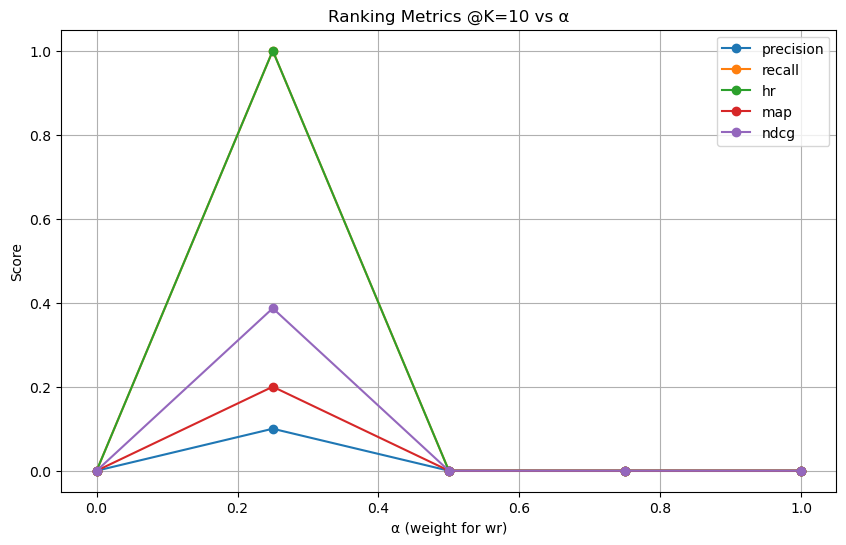

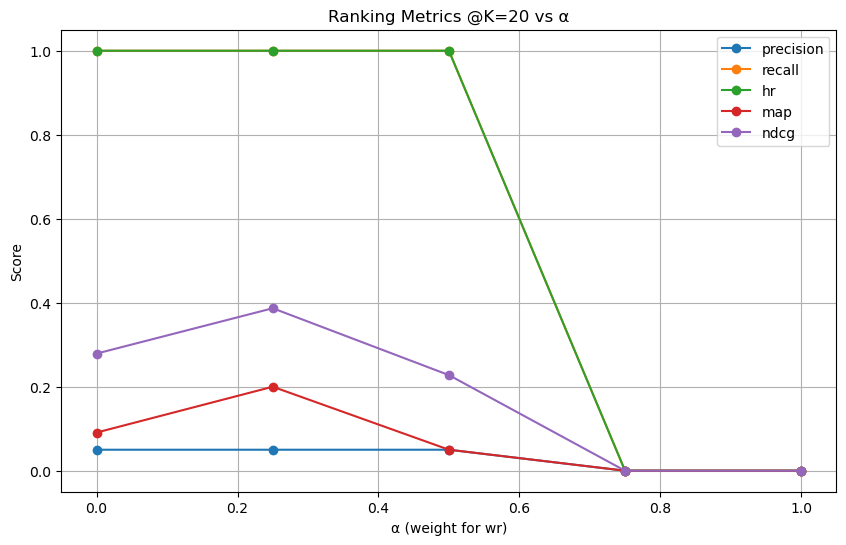

In [351]:
for K in Ks:
    plt.figure(figsize=(10,6))
    for metric in ["precision","recall","hr","map","ndcg"]:
        plt.plot(alphas, [agg_results[a][K][metric] for a in alphas], marker='o', label=metric)
    plt.title(f"Ranking Metrics @K={K} vs α")
    plt.xlabel("α (weight for wr)")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

So alpha=0.25 is the best one.